Name: T.M.N. Nimraka \
\
Index no: 225529P\
\
CM 3720 - Machine Learning

dataset: GIC Monthly Data Collection\
source: https://data.gov.lk/dataset/monthly-total-calls-received-gic-2021 \
model used: SARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
import re
from pmdarima import auto_arima

warnings.filterwarnings('ignore')

/Users/nithilathawalampitiya/Documents/Academics/University of Moratuwa/3rdYear/ML/Assignment/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load Data
df = pd.read_csv('GIC_Full_Dataset_2016_2025.csv')
df.head()

,Date,Month,Total no. of calls,No. of calls successfully answered,No. of calls answered within 30 seconds,Average waiting time in queue,No. of calls abandoned by the caller,Year,Month_Num
0,2016-01-01,Jan,182108.0,148708.0,94136.0,20.0,33400.0,2016,1
1,2016-02-01,Feb,158072.0,136620.0,84590.0,20.0,21452.0,2016,2
2,2016-03-01,Mar,164773.0,152380.0,123289.0,20.0,12393.0,2016,3
3,2016-04-01,Apr,133225.0,129037.0,121692.0,20.0,4188.0,2016,4
4,2016-05-01,May,210736.0,181385.0,123612.0,20.0,29351.0,2016,5


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('MS')
df = df[['Total no. of calls']].rename(columns={'Total no. of calls': 'Calls'})

# --- Stationarity Check ---
print("--- 1. Performing Stationarity Check ---")
result = adfuller(df['Calls'].dropna())
p_value = result[1]
if p_value > 0.05:
    print(f">> Data is Non-Stationary (p={p_value:.2f}). Setting d=1.")
    d_param = 1
else:
    print(f">> Data is Stationary (p={p_value:.2f}). Setting d=0.")
    d_param = 0

print(df.head())

--- 1. Performing Stationarity Check ---
>> Data is Non-Stationary (p=0.78). Setting d=1.
               Calls
Date                
2016-01-01  182108.0
2016-02-01  158072.0
2016-03-01  164773.0
2016-04-01  133225.0
2016-05-01  210736.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118 entries, 2016-01-01 to 2025-10-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Calls   118 non-null    float64
dtypes: float64(1)
memory usage: 1.8 KB


In [5]:
# Split Data
split_date = '2024-01-01'
train = df[df.index < split_date]
test = df[df.index >= split_date]

results = pd.DataFrame(index=test.index)
results['Actual'] = test['Calls']

In [6]:
results.head()

,Actual
Date,
2024-01-01,169250.169361
2024-02-01,148223.425567
2024-03-01,133920.126548
2024-04-01,112196.525143
2024-05-01,132756.618131


In [7]:
# --- MODEL 1: SARIMA ---
print("\n--- 2. Training SARIMA ---")
model_sarima = SARIMAX(train['Calls'], 
                       order=(1, d_param, 1), 
                       seasonal_order=(1, 1, 1, 12), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
fit_sarima = model_sarima.fit(disp=False)
results['SARIMA'] = fit_sarima.forecast(steps=len(test))

# --- MODEL 2: XGBoost ---
print("--- 3. Training XGBoost ---")
df_xgb = df.copy()

# A. Lags (Past context)
for lag in [1, 2, 3, 12]:
    df_xgb[f'Lag_{lag}'] = df_xgb['Calls'].shift(lag)

# B. Rolling Statistics (Recent trends)
df_xgb['Roll_Mean_3'] = df_xgb['Calls'].rolling(window=3).mean()
df_xgb['Roll_Std_6'] = df_xgb['Calls'].rolling(window=6).std()

# C. Time Components (Seasonality & Trend)
df_xgb['Month'] = df_xgb.index.month
df_xgb['Quarter'] = df_xgb.index.quarter
df_xgb['Year'] = df_xgb.index.year

# Drop NaNs created by lags/rolling (Only affects XGBoost data)
df_xgb.dropna(inplace=True)

# Split Features
X = df_xgb.drop(columns=['Calls'])
y = df_xgb['Calls']
X_train = X[X.index < split_date]
y_train = y[y.index < split_date]
X_test = X[X.index >= split_date]

model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
model_xgb.fit(X_train, y_train)
results['XGBoost'] = model_xgb.predict(X_test)

# --- MODEL 3: Prophet ---
print("--- 4. Training Prophet ---")
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Calls': 'y'})
train_prophet = df_prophet[df_prophet['ds'] < split_date]
test_prophet = df_prophet[df_prophet['ds'] >= split_date]

model_prophet = Prophet(seasonality_mode='multiplicative')
model_prophet.fit(train_prophet)
forecast = model_prophet.predict(test_prophet[['ds']])
results['Prophet'] = forecast['yhat'].values


--- 2. Training SARIMA ---
--- 3. Training XGBoost ---


21:18:10 - cmdstanpy - INFO - Chain [1] start processing
21:18:10 - cmdstanpy - INFO - Chain [1] done processing


--- 4. Training Prophet ---



--- Final Evaluation ---
          MAPE  RMSE
SARIMA   3.14%  4873
XGBoost  3.37%  5856
Prophet  3.29%  6508


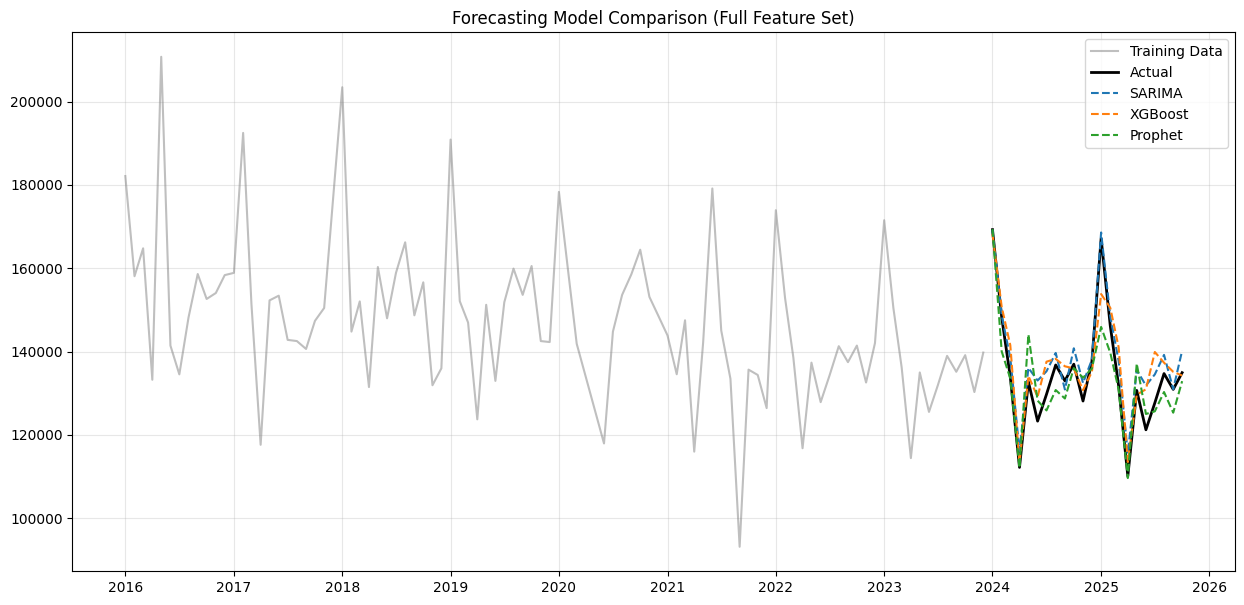

In [8]:
# --- EVALUATION ---
print("\n--- Final Evaluation ---")
metrics = {}
for model in ['SARIMA', 'XGBoost', 'Prophet']:
    mape = mean_absolute_percentage_error(results['Actual'], results[model])
    rmse = np.sqrt(mean_squared_error(results['Actual'], results[model]))
    metrics[model] = {'MAPE': f"{mape:.2%}", 'RMSE': int(rmse)}

print(pd.DataFrame(metrics).T)

# Plot
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['Calls'], label='Training Data', color='gray', alpha=0.5)
plt.plot(results.index, results['Actual'], label='Actual', color='black', linewidth=2)
plt.plot(results.index, results['SARIMA'], label='SARIMA', linestyle='--')
plt.plot(results.index, results['XGBoost'], label='XGBoost', linestyle='--')
plt.plot(results.index, results['Prophet'], label='Prophet', linestyle='--')
plt.title('Forecasting Model Comparison (Full Feature Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Hyper Parameter Tuning for SARIMA

In [9]:
# Load & Prep Data
df = pd.read_csv('GIC_Full_Dataset_2016_2025.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.asfreq('MS')
df = df[['Total no. of calls']].rename(columns={'Total no. of calls': 'Calls'})

# Use Time Series Cross-Validation Split
split_date = '2024-01-01'
train = df[df.index < split_date]['Calls']
test = df[df.index >= split_date]['Calls']

# Create validation set from training data (last 12 months of training)
val_split = '2023-01-01'
train_cv = train[train.index < val_split]
val_cv = train[train.index >= val_split]

print("Running auto_arima with out-of-sample validation...")
print("----------------------------------------------------------------")

# Use auto_arima with out-of-sample validation
auto_model = auto_arima(train_cv,
                        seasonal=True,
                        m=12,
                        start_p=0, max_p=2,      # Reduced complexity
                        start_q=0, max_q=2,
                        start_P=0, max_P=1,      # Reduced seasonal complexity
                        start_Q=0, max_Q=1,
                        d=None,
                        D=1,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True,
                        information_criterion='aic',
                        out_of_sample_size=len(val_cv))  # Use validation set

print("\n----------------------------------------------------------------")
print(f"Auto-ARIMA Best Model: SARIMA{auto_model.order}x{auto_model.seasonal_order}")

Running auto_arima with out-of-sample validation...
----------------------------------------------------------------
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1647.993, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1646.485, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1646.951, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1648.575, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1649.577, Time=0.02 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1648.149, Time=0.10 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1646.976, Time=0.06 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1646.602, Time=0.03 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1649.666, Time=0.10 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1648.503, Time=0.10 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1646.475, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1649.775, Time=0.02 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept  

In [10]:
# Compare multiple parameter sets
param_candidates = [
    (auto_model.order, auto_model.seasonal_order, "Auto-ARIMA Optimized"),
    ((1, 1, 1), (1, 1, 1, 12), "Simple Baseline"),
    ((0, 1, 1), (0, 1, 1, 12), "IMA Baseline"),
    ((2, 1, 2), (1, 1, 1, 12), "Complex Alternative")
]

results_comparison = []

for order, seasonal_order, name in param_candidates:
    try:
        # Train on validation split
        model = SARIMAX(train_cv, 
                       order=order, 
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False, 
                       enforce_invertibility=False)
        fit = model.fit(disp=False)
        
        # Validate on validation set
        val_pred = fit.forecast(steps=len(val_cv))
        val_mape = mean_absolute_percentage_error(val_cv, val_pred)
        val_rmse = np.sqrt(mean_squared_error(val_cv, val_pred))
        
        results_comparison.append({
            'Model': name,
            'Parameters': f"{order}x{seasonal_order}",
            'Val_MAPE': f"{val_mape:.2%}",
            'Val_RMSE': int(val_rmse)
        })
        
    except Exception as e:
        results_comparison.append({
            'Model': name,
            'Parameters': f"{order}x{seasonal_order}",
            'Val_MAPE': 'FAILED',
            'Val_RMSE': 'FAILED'
        })

# Display comparison
print("\n--- Validation Set Performance Comparison ---")
comparison_df = pd.DataFrame(results_comparison)
print(comparison_df)


--- Validation Set Performance Comparison ---
                  Model               Parameters Val_MAPE  Val_RMSE
0  Auto-ARIMA Optimized  (1, 0, 0)x(0, 1, 1, 12)    3.46%      5821
1       Simple Baseline  (1, 1, 1)x(1, 1, 1, 12)    4.56%      7405
2          IMA Baseline  (0, 1, 1)x(0, 1, 1, 12)    7.85%     11645
3   Complex Alternative  (2, 1, 2)x(1, 1, 1, 12)    4.04%      7435


In [11]:
# Select best model based on validation MAPE
best_model = comparison_df[comparison_df['Val_MAPE'] != 'FAILED'].sort_values('Val_MAPE').iloc[0]
print(f"\n✓ Best Model (Lowest Validation MAPE): {best_model['Model']}")
print(f"  Parameters: {best_model['Parameters']}")

param_str = best_model['Parameters']
# Parse string like "(1, 1, 1)x(1, 1, 1, 12)" into tuples
matches = re.findall(r'\(([^)]+)\)', param_str)
best_order = tuple(map(int, matches[0].split(', ')))
best_seasonal_order = tuple(map(int, matches[1].split(', ')))

print(f"\nExtracted Parameters:")
print(f"  order: {best_order}")
print(f"  seasonal_order: {best_seasonal_order}")


✓ Best Model (Lowest Validation MAPE): Auto-ARIMA Optimized
  Parameters: (1, 0, 0)x(0, 1, 1, 12)

Extracted Parameters:
  order: (1, 0, 0)
  seasonal_order: (0, 1, 1, 12)


In [12]:
split_date = '2024-01-01'
train = df[df.index < split_date]
test = df[df.index >= split_date]

In [13]:
train.head()

,Calls
Date,
2016-01-01,182108.0
2016-02-01,158072.0
2016-03-01,164773.0
2016-04-01,133225.0
2016-05-01,210736.0


In [14]:
test.head()

,Calls
Date,
2024-01-01,169250.169361
2024-02-01,148223.425567
2024-03-01,133920.126548
2024-04-01,112196.525143
2024-05-01,132756.618131


FINAL MODEL SELECTION ON TEST SET (2024-2025)

Training Validation-Best Model Model: (1, 0, 0) x (0, 1, 1, 12)
>> Success! MAPE: 3.40% | RMSE: 4967

Training Safe Baseline Model: (1, 1, 1) x (1, 1, 1, 12)
>> Success! MAPE: 3.14% | RMSE: 4873

COMPARISON ON TEST SET:
  Validation-Best: MAPE = 3.40%
  Safe Baseline:   MAPE = 3.14%

>> Using Safe Baseline (Better test performance)



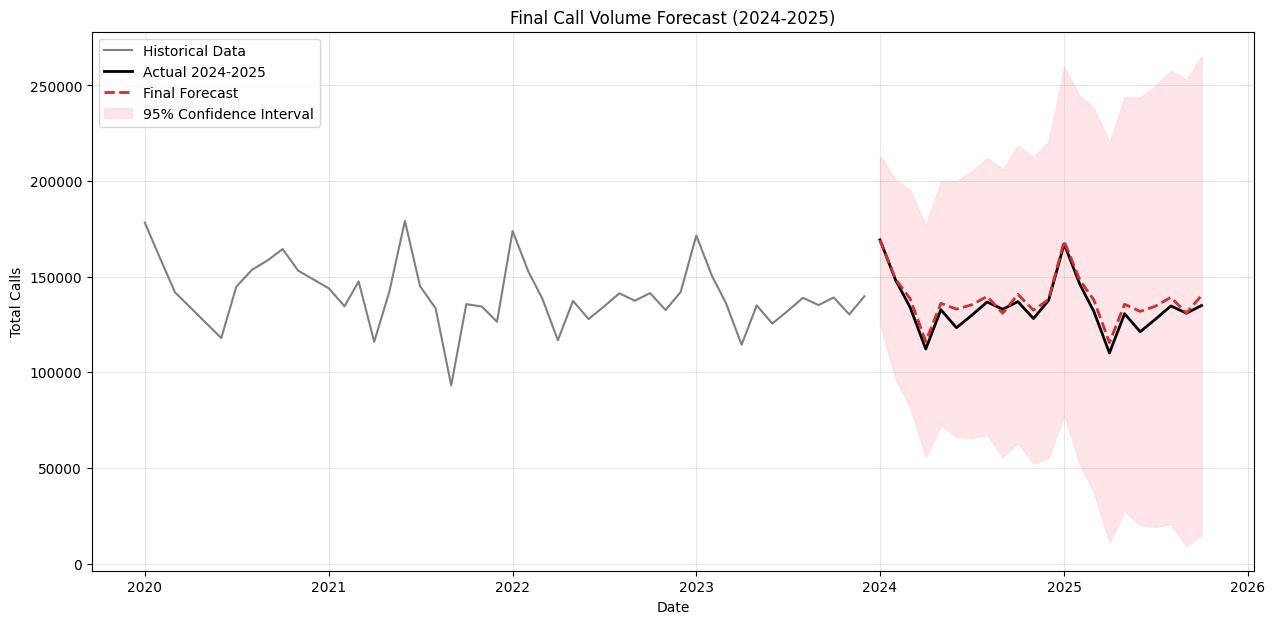

In [15]:
# Define Parameters from validation results
param_optimized = (best_order, best_seasonal_order)
# The "Safe" params as fallback
param_safe = ((1, 1, 1), (1, 1, 1, 12))

def train_and_evaluate(order, seasonal_order, name):
    print(f"\nTraining {name} Model: {order} x {seasonal_order}")
    try:
        model = SARIMAX(train['Calls'], 
                        order=order, 
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        fit = model.fit(disp=False)
        pred = fit.get_forecast(steps=len(test))
        y_pred = pred.predicted_mean
        
        # Check for explosion
        if y_pred.mean() > 10 * train['Calls'].max() or y_pred.mean() < 0:
            print(">> WARNING: Model exploded (unstable predictions).")
            return None, None, None

        mape = mean_absolute_percentage_error(test['Calls'], y_pred)
        rmse = np.sqrt(mean_squared_error(test['Calls'], y_pred))
        print(f">> Success! MAPE: {mape:.2%} | RMSE: {int(rmse)}")
        return y_pred, fit, pred.conf_int()
    except Exception as e:
        print(f">> Error: {e}")
        return None, None, None

# Attempt Training - Try validation-best model first
print("=" * 60)
print("FINAL MODEL SELECTION ON TEST SET (2024-2025)")
print("=" * 60)

y_final, model_final, conf_final = train_and_evaluate(param_optimized[0], param_optimized[1], "Validation-Best Model")

# If best model failed or performs worse, use safe baseline
if y_final is not None:
    # Also test safe model for comparison
    y_safe, model_safe, conf_safe = train_and_evaluate(param_safe[0], param_safe[1], "Safe Baseline")
    
    # Compare and select better one
    if y_safe is not None:
        mape_optimized = mean_absolute_percentage_error(test['Calls'], y_final)
        mape_safe = mean_absolute_percentage_error(test['Calls'], y_safe)
        
        print(f"\n{'='*60}")
        print("COMPARISON ON TEST SET:")
        print(f"  Validation-Best: MAPE = {mape_optimized:.2%}")
        print(f"  Safe Baseline:   MAPE = {mape_safe:.2%}")
        
        if mape_safe < mape_optimized:
            print(f"\n>> Using Safe Baseline (Better test performance)")
            y_final, model_final, conf_final = y_safe, model_safe, conf_safe
        else:
            print(f"\n>> Using Validation-Best Model")
        print(f"{'='*60}\n")
else:
    print("\nValidation-best model failed. Reverting to Safe Baseline...")
    y_final, model_final, conf_final = train_and_evaluate(param_safe[0], param_safe[1], "Safe Baseline")

# Final Visualization
plt.figure(figsize=(15, 7))
# Plot History (last 4 years for clarity)
plt.plot(train.index[-48:], train['Calls'].iloc[-48:], label='Historical Data', color='gray')
plt.plot(test.index, test['Calls'], label='Actual 2024-2025', color='black', linewidth=2)
plt.plot(test.index, y_final, label='Final Forecast', color='#D32F2F', linestyle='--', linewidth=2)

# Confidence Interval
if conf_final is not None:
    plt.fill_between(test.index, conf_final.iloc[:, 0], conf_final.iloc[:, 1], color='#FFCDD2', alpha=0.5, label='95% Confidence Interval')

plt.title('Final Call Volume Forecast (2024-2025)')
plt.xlabel('Date')
plt.ylabel('Total Calls')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()